# Demonstrace naší knihovny (Tým 12)

## Importy

Nejdříve přidáme složku s naší knihovnou do `sys.path`. Poté ji lze jednoduše importovat.

In [1]:
import sys
import os
from os import path
import re
import unicodedata
import pandas as pd
import matplotlib.pyplot as plt

library_path = path.abspath(path.join(os.getcwd(), "../MH_decipher"))
if library_path not in sys.path:
    sys.path.append(library_path)

import mhdecipher # type: ignore

## Konstanty a pomocné funkce

In [2]:
IMPORT_DIR_PATH = "./import"
EXPORT_DIR_PATH = "../export"

In [3]:
def read_file(filepath: str) -> str:
    with open(filepath, "r", encoding="utf-8") as f:
        return f.read()

def write_file(filepath: str, data: str) -> str:
    with open(filepath, "w", encoding="utf-8") as f:
        return f.write(data)

def remove_diacritics(text: str) -> str:
    normalized_str = unicodedata.normalize("NFD", text)
    return "".join(c for c in normalized_str if unicodedata.category(c) != "Mn")

## Šifrování

In [4]:
plaintext = "BYL_POZDNI_VECER_PRVNI_MAJ_VECERNI_MAJ_BYL_LASKY_CAS"
key = "DEFGHIJKLMNOPQRSTUVWXYZ_ABC"

ciphertext = mhdecipher.substitute_encrypt(plaintext, key)

print(ciphertext)

EAOCSRBGQLCYHFHUCSUYQLCPDMCYHFHUQLCPDMCEAOCODVNACFDV


## Dešifrování

In [5]:
ciphertext = "EAOCSRBGQLCYHFHUCSUYQLCPDMCYHFHUQLCPDMCEAOCODVNACFDV"
key = "DEFGHIJKLMNOPQRSTUVWXYZ_ABC"

plaintext = mhdecipher.substitute_decrypt(ciphertext, key)

print(plaintext)

BYL_POZDNI_VECER_PRVNI_MAJ_VECERNI_MAJ_BYL_LASKY_CAS


## Získání bigramů

In [6]:
bigrams = mhdecipher.get_bigrams("KRYPTOSYSTEM")
print(bigrams)

['KR', 'RY', 'YP', 'PT', 'TO', 'OS', 'SY', 'YS', 'ST', 'TE', 'EM']


## Vytvoření teoretické bigramové matice

In [7]:
ref_text = read_file("./Krakatit.txt")

# Extract only the actual text of the chapters
chapters_text = re.findall(r"Údaje o textu\n.*?\nPodtitulek: .*?\nO. Štorch-Marien 1924\n\n(.*?)\n\n\n\n\n\n", ref_text, re.DOTALL)

# Replace new lines in each chapter with a space
chapters_text = [s.replace("\n\n", " ") for s in chapters_text]

# Join the chapters into a single string
ref_text = "\n\n".join(chapters_text)

# Convert the text to our alphabet
ref_text = ref_text.upper()
ref_text = ref_text.replace(" ", "_")
ref_text = remove_diacritics(ref_text)

# Remove all characters that aren't in the alphabet and aren't a whitespace character
ref_text = re.sub(f"[^{mhdecipher.alphabet}\\s]", "", ref_text)

print(f"Using {len(ref_text)} characters of text to make a reference transition matrix.")

bigrams = mhdecipher.get_bigrams(ref_text)
TM_ref: pd.DataFrame = mhdecipher.transition_matrix(bigrams)

# Visualize the matrix
TM_ref.style.format().background_gradient(axis=None)

Using 435131 characters of text to make a reference transition matrix.


,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z,_
A,0.000046,0.001411,0.002379,0.003422,0.000005,0.000207,0.000113,0.001411,0.000207,0.001409,0.005612,0.009296,0.003829,0.004780,0.000023,0.001269,0.000002,0.003001,0.004364,0.005212,0.000340,0.003587,0.000002,0.000005,0.000002,0.002673,0.026775
B,0.001020,0.000002,0.000032,0.000018,0.001926,0.000002,0.000002,0.000002,0.000864,0.000062,0.000062,0.000648,0.000007,0.000273,0.001990,0.000002,0.000002,0.001232,0.000051,0.000018,0.001059,0.000007,0.000002,0.000002,0.003723,0.000032,0.000083
C,0.001053,0.000002,0.000055,0.000002,0.006168,0.000002,0.000002,0.007365,0.005051,0.000002,0.001482,0.000572,0.000032,0.000917,0.002273,0.000030,0.000002,0.000014,0.000007,0.000448,0.000159,0.000034,0.000002,0.000002,0.000011,0.000002,0.001710
D,0.002992,0.000138,0.000262,0.000083,0.005104,0.000002,0.000002,0.000103,0.002535,0.000044,0.000271,0.001671,0.000122,0.001609,0.004711,0.000216,0.000002,0.001236,0.000285,0.000207,0.001030,0.000724,0.000002,0.000002,0.002404,0.000037,0.002562
E,0.000048,0.001714,0.003987,0.004872,0.000011,0.000039,0.000179,0.002220,0.000055,0.002937,0.003291,0.006798,0.005725,0.006653,0.000209,0.001089,0.000002,0.002429,0.004130,0.003259,0.000149,0.001645,0.000005,0.000129,0.000002,0.003217,0.033550
F,0.000198,0.000002,0.000002,0.000002,0.000064,0.000129,0.000002,0.000002,0.000133,0.000002,0.000002,0.000032,0.000002,0.000014,0.000136,0.000002,0.000002,0.000087,0.000002,0.000124,0.000046,0.000002,0.000002,0.000002,0.000023,0.000002,0.000057
G,0.000122,0.000002,0.000002,0.000002,0.000136,0.000002,0.000002,0.000011,0.000110,0.000002,0.000002,0.000030,0.000011,0.000041,0.000083,0.000002,0.000002,0.000177,0.000002,0.000002,0.000044,0.000002,0.000002,0.000002,0.000007,0.000002,0.000071
H,0.002135,0.000011,0.000370,0.000044,0.000627,0.000002,0.000002,0.000002,0.000076,0.000002,0.000055,0.003877,0.000191,0.001016,0.005665,0.000002,0.000002,0.001448,0.000014,0.000575,0.000919,0.000540,0.000002,0.000002,0.000745,0.000005,0.002349
I,0.000126,0.000310,0.004461,0.001570,0.000237,0.000030,0.000076,0.000423,0.000115,0.000421,0.001979,0.005745,0.003174,0.003426,0.000097,0.000278,0.000002,0.001000,0.002769,0.003702,0.000051,0.002158,0.000009,0.000002,0.000002,0.001202,0.017916
J,0.003826,0.000025,0.000037,0.000600,0.006867,0.000002,0.000002,0.000021,0.003603,0.000011,0.000030,0.000046,0.000329,0.000230,0.000092,0.000023,0.000002,0.000014,0.001942,0.000184,0.000103,0.000083,0.000002,0.000002,0.000002,0.000007,0.000763


## Věrohodnost

Kód předpokládá vygenerovanou bigramovou matici z minulé sekce.

In [8]:
plausibility = mhdecipher.plausibility("BYL_POZDNI_VECER_PRVNI_MAJ_VECERNI_MAJ_BYL_LASKY_CAS", TM_ref)
print(plausibility)

plausibility = mhdecipher.plausibility("EAOCSRBGQLCYHFHUCSUYQLCPDMCYHFHUQLCPDMCEAOCODVNACFDV", TM_ref)
print(plausibility)

-9.300312876021257
-9.418745922462847


Čitelný český text má větší věrohodnost než zašifrovaný/nečitelný text.

## Provedení kryptoanalýzy na zašifrovaném textu

Kód předpokládá vygenerovanou bigramovou matici z minulé sekce.

In [9]:
ciphertext = read_file("./import/text_1000_sample_1_ciphertext.txt")
iter = 20_000
# start_key = "ABCDEFGHIJKLMNOPQRSTUVWXYZ_"
start_key = None  # the function will generate a random start key

key, decrypted_text, p = mhdecipher.prolom_substitute(ciphertext, TM_ref, iter, start_key)

print(f"Key: {key}")
print(f"Decrypted text: {decrypted_text}")
print(f"P: {p}")

Iteration 0 log plausibility: -9.383943998513228
Iteration 1000 log plausibility: -7.3422812335568235
Iteration 2000 log plausibility: -7.214949522441165
Iteration 3000 log plausibility: -7.119662583943523
Iteration 4000 log plausibility: -7.119662583943523
Iteration 5000 log plausibility: -7.19865452582809
Iteration 6000 log plausibility: -7.229632973707987
Iteration 7000 log plausibility: -7.119662583943523
Iteration 8000 log plausibility: -7.119662583943523
Iteration 9000 log plausibility: -7.160883130525047
Iteration 10000 log plausibility: -7.336902880139702
Iteration 11000 log plausibility: -7.174651081835201
Iteration 12000 log plausibility: -7.227133194421576
Iteration 13000 log plausibility: -7.104311308046093
Iteration 14000 log plausibility: -7.274215304620009
Iteration 15000 log plausibility: -7.205606391043817
Iteration 16000 log plausibility: -7.147286470643969
Iteration 17000 log plausibility: -7.104311308046093
Iteration 18000 log plausibility: -7.104311308046093
Iterat

## Provedení kryptoanalýzy na zašifrovaných textech ze zadání

In [10]:
for filename in os.listdir(IMPORT_DIR_PATH):
    m = re.fullmatch("^(.*)_ciphertext.txt$", filename)
    if m is None:
        continue

    ciphertext_filepath = path.join(IMPORT_DIR_PATH, filename)
    plaintext_filepath = path.join(EXPORT_DIR_PATH, m.expand(r"\1_plaintext.txt"))
    key_filepath = path.join(EXPORT_DIR_PATH, m.expand(r"\1_key.txt"))

    if path.isfile(plaintext_filepath) or path.isfile(plaintext_filepath):
        print(f"Skipping {filename} because the plaintext or key already exists")
        continue

    ciphertext = read_file(ciphertext_filepath)
    iter = 20_000

    print(f"Cracking {filename}")
    key, decrypted_text, p = mhdecipher.prolom_substitute(ciphertext, TM_ref, iter)
    print()

    write_file(plaintext_filepath, decrypted_text)
    write_file(key_filepath, key)

Cracking text_1000_sample_10_ciphertext.txt
Iteration 0 log plausibility: -9.839680401373602
Iteration 1000 log plausibility: -7.86205627570536
Iteration 2000 log plausibility: -7.459727820948874
Iteration 3000 log plausibility: -7.445909419046119
Iteration 4000 log plausibility: -7.805064700390442
Iteration 5000 log plausibility: -7.352488430715946
Iteration 6000 log plausibility: -7.231719085149649
Iteration 7000 log plausibility: -7.2045224994044474
Iteration 8000 log plausibility: -7.2045224994044474
Iteration 9000 log plausibility: -7.2045224994044474
Iteration 10000 log plausibility: -7.205012524710894
Iteration 11000 log plausibility: -7.061210674805084
Iteration 12000 log plausibility: -7.095260439750901
Iteration 13000 log plausibility: -7.061210674805084
Iteration 14000 log plausibility: -7.061210674805084
Iteration 15000 log plausibility: -7.061210674805084
Iteration 16000 log plausibility: -7.433542683172194
Iteration 17000 log plausibility: -7.097936079179206
Iteration 180

## Analýza úspěšnosti prolomení

Analýza není jednoduchá, protože nemáme k dispozici správné klíče či originální texty. Všimli jsme si ovšem, že se jedná o úryvky z díla Krakatit. Budeme tedy uvažovat, že mezery v dešifrovaném textu našim algoritmem, jsou správně, a na jejich základě zkusíme najít stejné úseky v originálním díle.

Original plaintext for text_500_sample_7 was not found
Original plaintext for text_500_sample_16 was not found
Original plaintext for text_1000_sample_14 was not found


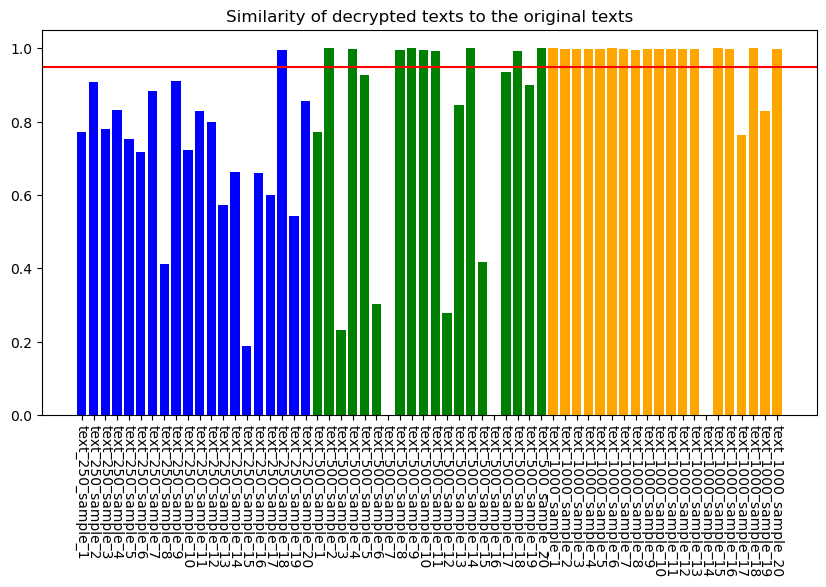

In [11]:
def similarity_score(str1: str, str2: str) -> int:
    if len(str1) != len(str2):
        raise ValueError("Lengths of strings don't match")
    
    l = len(str1)
    match_count = 0
    for i in range(l):
        if str1[i] == str2[i]:
            match_count += 1
    
    return match_count / l

fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title("Similarity of decrypted texts to the original texts")

decrypted_plaintexts = []

# Load the decrypted texts
for filename in os.listdir(EXPORT_DIR_PATH):
    m = re.fullmatch("^text_(.*)_sample_(.*)_plaintext.txt$", filename)
    if m is None:
        continue
    
    plaintext_filepath = path.join(EXPORT_DIR_PATH, filename)
    decrypted_plaintext = read_file(plaintext_filepath)

    length = int(m.group(1))
    id = int(m.group(2))
    decrypted_plaintexts.append((length, id, decrypted_plaintext))

decrypted_plaintexts.sort()

labels = []
similarity_scores = []
colors = []

# Find the original plaintexts and calculate the similarity
for length, id, decrypted_plaintext in decrypted_plaintexts:
    label = f"text_{length}_sample_{id}"
    labels.append(label)

    pattern_words = [f"[A-Z]{{{len(c)}}}" for c in decrypted_plaintext.split("_")]
    pattern = "_".join(pattern_words)
    matches = re.findall(pattern, ref_text)
    if len(matches) == 0:
        print(f"Original plaintext for {label} was not found")
        similarity_scores.append(0)
        colors.append("red")
        continue
    if len(matches) > 1:
        print(f"More than 1 match was found for {label}")
        similarity_scores.append(0)
        colors.append("red")
        continue
    
    original_plaintext = matches[0]

    
    similarity_scores.append(similarity_score(decrypted_plaintext, original_plaintext))
    match length:
        case 250: colors.append("blue")
        case 500: colors.append("green")
        case 1000: colors.append("orange")
        case _: colors.append("red")


# Make a plot of similarities
ax.bar(labels, similarity_scores, color=colors)
ax.tick_params(axis="x", rotation=270)
ax.axhline(0.95, color="red")
plt.show()

Graf zobrazuje podobnost dešifrovaných textů a originálních textů. Různé délky šifrovaných textů jsou barevně rozlišeny. Červená přímka značí 95% podobnost.

Pokud se nepodařilo jednoznačně najít originální text, tak má sloupec podobnost 0.

Je vidět, že čím delší šifrovaný text máme, tím větší šance na úspěšné prolomení.

Nízká podobnost u krátkých textů není způsobena špatným prolomovacím algoritmem nebo nízkým počtem iterací, neboť tyto dešifrované texty dokonce mají vyšší hodnotu věrohodnosti než originální text. Krátký šifrovaný text zkrátka není vhodný pro tento typ kryptoanalýzy.